E-ticaret Müşteri Segmentasyonu ve CLV Analizi
-

#### Kütüphaneler

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    davies_bouldin_score,
    calinski_harabasz_score
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data

#### Veri Yükleme

In [5]:
df = pd.read_csv("ecommerce_customer_behavior_dataset_v2.csv")
df["Date"] = pd.to_datetime(df["Date"])

print("Transaction-level Shape:", df.shape)
df.head()


Transaction-level Shape: (17049, 18)


,Order_ID,Customer_ID,Date,Age,Gender,City,Product_Category,Unit_Price,Quantity,Discount_Amount,Total_Amount,Payment_Method,Device_Type,Session_Duration_Minutes,Pages_Viewed,Is_Returning_Customer,Delivery_Time_Days,Customer_Rating
0,ORD_000001-1,CUST_00001,2023-05-29,40,Male,Ankara,Books,29.18,1,0.00,29.18,Digital Wallet,Mobile,14,9,True,13,4
1,ORD_000001-2,CUST_00001,2023-10-12,40,Male,Ankara,Home & Garden,644.40,1,138.05,506.35,Credit Card,Desktop,14,8,True,6,2
2,ORD_000001-3,CUST_00001,2023-12-05,40,Male,Ankara,Sports,332.82,5,0.00,1664.10,Credit Card,Mobile,15,10,True,9,4
3,ORD_000002-1,CUST_00002,2023-05-11,33,Male,Istanbul,Food,69.30,5,71.05,275.45,Digital Wallet,Desktop,16,13,True,4,4
4,ORD_000002-2,CUST_00002,2023-06-16,33,Male,Istanbul,Beauty,178.15,3,0.00,534.45,Credit Card,Mobile,14,7,True,6,4


#### Customer - Level Veri Oluşturma
Aynı müşterinin birden fazla işlemi olabileceği için, segmentasyon müşteri bazında yapılmıştır.

In [6]:
customer_df = df.groupby("Customer_ID").agg({
    "Total_Amount": "sum",
    "Quantity": "sum",
    "Discount_Amount": "sum",
    "Session_Duration_Minutes": "mean",
    "Pages_Viewed": "mean",
    "Delivery_Time_Days": "mean",
    "Is_Returning_Customer": "max",
    "Order_ID": "count"
}).reset_index()

customer_df.rename(columns={"Order_ID": "Total_Orders"}, inplace=True)

print("Customer-level Shape:", customer_df.shape)
customer_df.head()


Customer-level Shape: (5000, 9)


,Customer_ID,Total_Amount,Quantity,Discount_Amount,Session_Duration_Minutes,Pages_Viewed,Delivery_Time_Days,Is_Returning_Customer,Total_Orders
0,CUST_00001,2199.63,7,138.05,14.333333,9.000000,9.333333,True,3
1,CUST_00002,809.90,8,71.05,15.000000,10.000000,5.000000,True,2
2,CUST_00003,3030.81,7,0.00,10.500000,8.500000,6.000000,True,2
3,CUST_00004,383.22,5,97.78,16.000000,15.000000,4.000000,False,1
4,CUST_00005,2422.73,8,0.00,12.666667,9.333333,5.666667,True,3


#### Feature Seçimi ve Ölçeklendirme

In [7]:
features = [
    "Total_Amount",
    "Quantity",
    "Session_Duration_Minutes",
    "Pages_Viewed",
    "Discount_Amount",
    "Delivery_Time_Days"
]

X = customer_df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


#### K-Means Segmentasyon

In [10]:
kmeans = KMeans(n_clusters=4, random_state=42)
customer_df["Customer_Segment"] = kmeans.fit_predict(X_scaled)

customer_df["Customer_Segment"].value_counts()


Customer_Segment
1    1796
3    1738
2    1220
0     246
Name: count, dtype: int64

#### Segment Analizi 

In [11]:
segment_profile = customer_df.groupby("Customer_Segment")[features].mean().round(2)
segment_counts = customer_df["Customer_Segment"].value_counts().sort_index()
segment_returning_rate = (
    customer_df.groupby("Customer_Segment")["Is_Returning_Customer"]
    .mean()
    .round(3)
)

summary = segment_profile.copy()
summary["Customer_Count"] = segment_counts
summary["Returning_Rate"] = segment_returning_rate

summary


,Total_Amount,Quantity,Session_Duration_Minutes,Pages_Viewed,Discount_Amount,Delivery_Time_Days,Customer_Count,Returning_Rate
Customer_Segment,,,,,,,,
0,16999.09,19.44,14.52,9.10,1795.44,6.36,246,0.992
1,2160.95,6.78,14.96,10.25,100.61,6.79,1796,0.902
2,8288.92,18.53,14.51,8.98,320.04,6.42,1220,1.000
3,2073.49,6.78,14.16,7.68,101.84,6.34,1738,0.902


#### Segment Görselleştirme

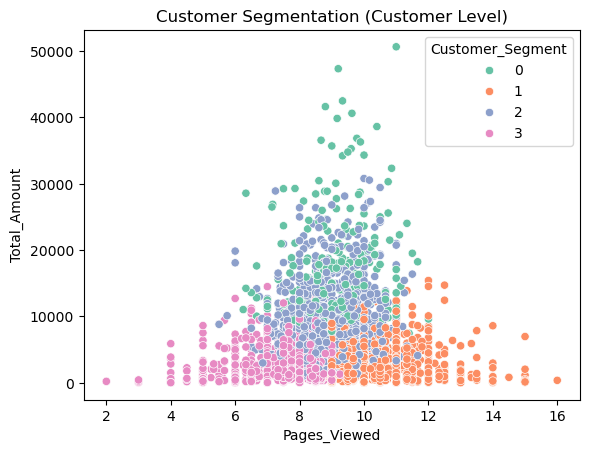

In [12]:
sns.scatterplot(
    data=customer_df,
    x="Pages_Viewed",
    y="Total_Amount",
    hue="Customer_Segment",
    palette="Set2"
)
plt.title("Customer Segmentation (Customer Level)")
plt.show()


### DERİN ÖĞRENME
Bu aşamada K-Means ile oluşturulan segmentler, denetimli öğrenme kullanılarak tahmin edilmiştir.

#### MLP Modeli

In [13]:
X_dl = X_scaled
y_dl = customer_df["Customer_Segment"]
y_dl_cat = to_categorical(y_dl)

X_train, X_test, y_train, y_test = train_test_split(
    X_dl, y_dl_cat, test_size=0.2, random_state=42
)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(4, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4762 - loss: 1.1464 - val_accuracy: 0.6050 - val_loss: 0.8218
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7688 - loss: 0.6201 - val_accuracy: 0.9100 - val_loss: 0.4308
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9341 - loss: 0.3100 - val_accuracy: 0.9400 - val_loss: 0.2431
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9597 - loss: 0.1953 - val_accuracy: 0.9513 - val_loss: 0.1773
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9709 - loss: 0.1468 - val_accuracy: 0.9625 - val_loss: 0.1406
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9744 - loss: 0.1186 - val_accuracy: 0.9625 - val_loss: 0.1193
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9791 - loss: 0.1009 - val_accuracy: 0.9700 - val_loss: 0.1014
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9800 - loss: 0.0890 - val_accuracy: 0.

#### Model Değerlendirme

Accuracy: 0.983
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


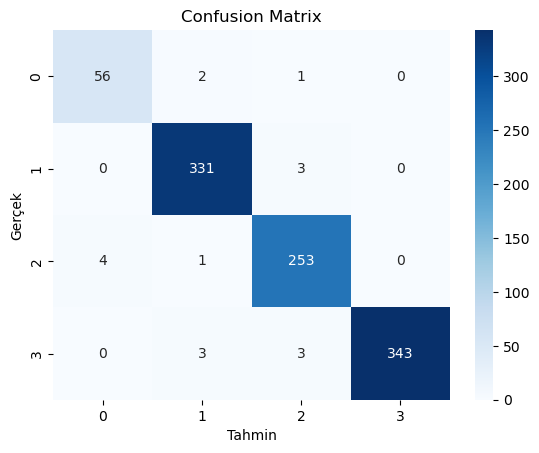

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        59
           1       0.98      0.99      0.99       334
           2       0.97      0.98      0.98       258
           3       1.00      0.98      0.99       349

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.97      1000
weighted avg       0.98      0.98      0.98      1000



In [14]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy: {accuracy:.3f}")

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred))


#### Kümeleme Model Değerlendirme

In [15]:
db_index = davies_bouldin_score(X_scaled, customer_df["Customer_Segment"])
ch_index = calinski_harabasz_score(X_scaled, customer_df["Customer_Segment"])

print(f"Davies–Bouldin Index: {db_index:.4f}")
print(f"Calinski–Harabasz Index: {ch_index:.2f}")


Davies–Bouldin Index: 1.6629
Calinski–Harabasz Index: 1016.67


#### CLV Analizi

In [16]:
clv_df = summary_data_from_transaction_data(
    df,
    customer_id_col="Customer_ID",
    datetime_col="Date",
    monetary_value_col="Total_Amount"
)

clv_df = clv_df[clv_df["frequency"] > 0]

bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(clv_df["frequency"], clv_df["recency"], clv_df["T"])

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(clv_df["frequency"], clv_df["monetary_value"])

clv_df["Tahmini_Gelecek_Deger"] = ggf.customer_lifetime_value(
    bgf,
    clv_df["frequency"],
    clv_df["recency"],
    clv_df["T"],
    clv_df["monetary_value"],
    time=6,
    freq="D",
    discount_rate=0.01
)

clv_df["CLV_Segment"] = pd.qcut(
    clv_df["Tahmini_Gelecek_Deger"],
    4,
    labels=["D", "C", "B", "A"]
)

clv_df.head()


,frequency,recency,T,monetary_value,Tahmini_Gelecek_Deger,CLV_Segment
Customer_ID,,,,,,
CUST_00001,2.0,190.0,301.0,1085.225,1607.483989,B
CUST_00002,1.0,36.0,319.0,534.450,412.912809,D
CUST_00003,1.0,310.0,392.0,2634.250,3230.605660,A
CUST_00005,2.0,97.0,375.0,410.860,436.716890,D
CUST_00006,2.0,34.0,245.0,275.240,371.057359,D


#### CLV Görselleştirme

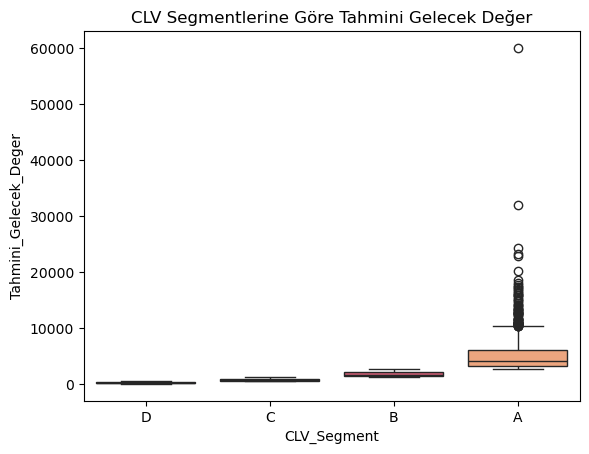

In [17]:
sns.boxplot(
    x="CLV_Segment",
    y="Tahmini_Gelecek_Deger",
    data=clv_df,
    palette="magma"
)
plt.title("CLV Segmentlerine Göre Tahmini Gelecek Değer")
plt.show()
